#  A tour of transmorph *matching* modules

**Matching** algorithms estimate a similarity measure between cells across datasets. They are the core component of our integration framework, as their quality directly influences cell-cell proximity in the final embedding. We will use here a small toy dataset to illustrate each matching available in transmorph, with use case advices. We will also showcase how to implement a custom matching which can be used within a **transmorph** model.

## Toy dataset and plotting function

Let us start by loading a small dataset containing a handful of points in a 2D space. This will allow us to illustrate philosophy behind each matching algorithm.

In [1]:
from transmorph.datasets import load_test_datasets_small

datasets = load_test_datasets_small()

We define a custom plotting function, that will display each dataset in their common 2D space together with matching edges if necessary.

In [ ]:
import anndata as ad
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix
from typing import List, Optional

from mpl_toolkits.axes_grid1 import make_axes_locatable

SHAPES = ['s', 'o']
COLORS = ['red', 'blue']

def scatter_plot_with_matching(datasets: List[ad.AnnData], matching: Optional[csr_matrix] = None) -> None:
    """
    Custom scatter_plot function that can also plot a matching between dots.
    """
    fig = plt.figure(figsize=(5,5))
    ax_scatter = fig.add_subplot(111)
    
    # Scatter plot
    for (adata_name, adata), color in zip(datasets.items(), COLORS):
        for dclass, shape in zip((0, 1), SHAPES):
            ax_scatter.scatter(
                *adata.X[adata.obs['class'] == dclass].T, 
                s=40,
                c=color,
                marker=shape
            )
    
    # Matching edges
    if matching is not None:
        X, Y = datasets['src'].X, datasets['ref'].X
        T_coo = matching.tocoo()
        vmax = T_coo.data.max()
        for i, j, v in zip(T_coo.row, T_coo.col, T_coo.data):
            plt.plot([X[i][0], Y[j][0]], [X[i][1], Y[j][1]], c='k', linewidth=1, alpha=v/vmax)
        plt.plot([], [], c='k', linewidth=1, label="Matching")
            
    # Annotations
    ax_scatter.set_xticks([])
    ax_scatter.set_yticks([])
    ax_scatter.set_xlabel("Feature 1", fontsize=16)
    ax_scatter.set_ylabel("Feature 2", fontsize=16)
    
    # Legend outside of plot
    for (adata_name, adata), color in zip(datasets.items(), COLORS):
        ax_scatter.scatter([], [], c=color, marker="h", label=f"Dataset {adata_name}")
    for dclass, shape in zip((0, 1), SHAPES):
        ax_scatter.scatter([], [], c="k", marker=shape, label=f"Sample type {dclass}")
    
    divider = make_axes_locatable(ax_scatter)
    ax_legend = divider.append_axes("right", size="5%", pad=0.1)
    handles, labels = ax_scatter.get_legend_handles_labels()
    for label in labels:
        ax_legend.scatter([], [], label=label)
    legend = ax_legend.legend(
        handles,
        labels,
        fontsize=12,
        loc="center left",
    )
    ax_legend.axis("off")

Let us have a look at our two small datasets. They simulate a simple batch effect along the $x$ axis, and a simple biological effect along the $y$ axis with two point types. The goal here is to match points across datasets so that edges link points of the same type.

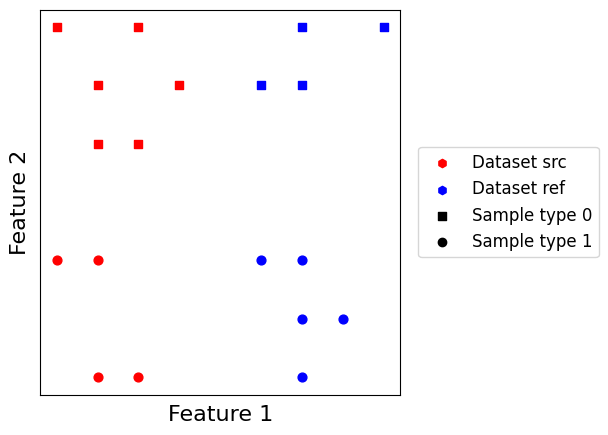

In [2]:
scatter_plot_with_matching(datasets)

Before starting, we define two simple helper functions. *create_model_matching* allows us to generate a small, output-less model containing a matching algorithm. *get_matching_matrix* allows to retrieve the matching computed by the model as a CSR matrix. Note that some matchings are nonsymmetrical, and in this case it will only retrieve the matrix from dataset "src" to dataset "ref".

J:\Code\PHD\transmorph_package\transmorph\src\transmorph\engine\traits\canlog.py:64: UserWarning: No output layer reachable from input. This pipeline will not write results in AnnData objects.
  warnings.warn(msg)


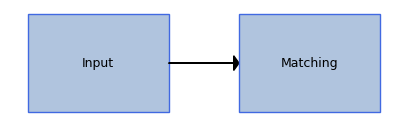

In [3]:
from transmorph.engine import Model
from transmorph.engine.layers import LayerInput, LayerMatching
from transmorph.utils.plotting import plot_model

def create_model_matching(matching=None):
    # Creates a minimalist model endowed with a set of transformations

    # Initializes layers
    layer_input = LayerInput()
    layer_matching = LayerMatching(matching=matching)

    # Setup connections
    layer_input.connect(layer_matching)

    # Build model
    model = Model(input_layer=layer_input)
    return model

def get_matching_matrix(model: Model) -> csr_matrix:
    return model.layers[1].matching_matrices[0, 1]

# Creating an empty model
plot_model(create_model_matching())

We observe a warning is triggered, because we did not provide an output layer to the model. This is expected here, so this is not an issue.

## Label-based matching

Label-based matching is a simple case of supervised matching. It works by matching points which share the same label across datasets. This matching can be computed efficiently, does not depend on datasets embedding, which can be an advantage when no clear metric can be defined between them, and cannot match cells with different cell labels. 

On the other hand, it requires to assess cell labels beforehand which is a strong bias and necessitates a third party algorithm. It also tends to generate a very high number of matching edges, which can severely reduce performance of subsequent pipeline steps. This also implies every sample is matched to all samples with its label, meaning this matching is insensitive to variations within a label, which tends to blur results. Overall, it is a matching which is not recommended in the general case for these reasons, but which could see use in particular scenarios, such as pipeline testings or when high confidence labels are available.

In [48]:
from transmorph.engine.matching import Labels

# We have to explicitly provide the .obs key containing labels
model_labels = create_model_matching(Labels(label_obs="class"))
model_labels.fit(datasets)

CUSTOM_MODEL > Transmorph model is initializing.
CUSTOM_MODEL > Ready to start the integration of 2 datasets, 19 total samples.
CUSTOM_MODEL > Running layer LAYER_INPUT#18.
CUSTOM_MODEL > Running layer LAYER_MATCHING#19.
LAYER_MATCHING#19 > Calling matching MATCHING_LABELS.


J:\Code\PHD\transmorph_package\transmorph\src\transmorph\engine\traits\canlog.py:64: UserWarning: No output layer reachable from input. This pipeline will not write results in AnnData objects.
  warnings.warn(msg)


We can then plot this matching's result using our custom plotting function. As we expected, we obtain two disjoint bipartite graphs, one for each sample type which maps every point of a dataset to each point in the other dataset with similar label. Let us now move to more interesting matching algorithms.

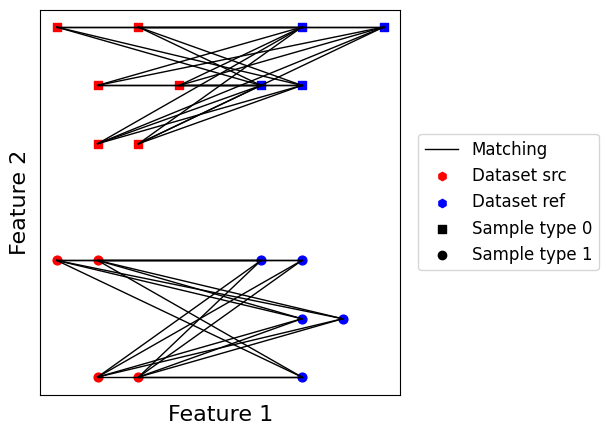

In [58]:
scatter_plot_with_matching(datasets, get_matching_matrix(model_labels))

## Batch $k$-nearest neighbors matching

For $k$ a positive integer, batch $k$-nearest neighbors is derived from the well-known $k$-nearest neighbors algorithm. It requires two batches $\mathbf{X}_a$ and $\mathbf{X}_b$ to be embedded in a metric space $(\mathcal{X}, d)$, and works best when batch effect is orthogonal to biological signal of interest which seems to be a reasonable assumption in practice for single-cell data.

Batch $k$-nearest neighbors derived algorithm have been successfully applied to dataset integration in the single-cell field, for instance in the [BBKNN](https://github.com/Teichlab/bbknn) tool. It tends to yield high quality matching results when the orthogonality of batch effect hypothesis is verified, and only needs the tuning of the $k$ parameter (typically set between 10 and 50 in our applications). Furthermore, it also returns a much smaller number of edges compared to label matching, of the order of $kn$, which greatly improves performance of subsequent pipeline steps.

In [35]:
from transmorph.engine.matching import BKNN

# Here, every point will be matched to its 2 nearest neighbors
# in the other batch.
model_bknn = create_model_matching(BKNN(n_neighbors=2))
model_bknn.fit(datasets)

CUSTOM_MODEL > Transmorph model is initializing.
CUSTOM_MODEL > Ready to start the integration of 2 datasets, 19 total samples.
CUSTOM_MODEL > Running layer LAYER_INPUT#34.
CUSTOM_MODEL > Running layer LAYER_MATCHING#35.
LAYER_MATCHING#35 > Calling matching MATCHING_MNN.


J:\Code\PHD\transmorph_package\transmorph\src\transmorph\engine\traits\canlog.py:64: UserWarning: No output layer reachable from input. This pipeline will not write results in AnnData objects.
  warnings.warn(msg)


We first observe this matching is nonsymmetrical, and matches all points from the query dataset while leaving unmatched points into the reference dataset. It also returns a lower number of edges compared to label matching, and some of them match points of different label. This is still quite accurate for a purely unsupervised matching, and works especially well when batch effects are orthogonal to the signal of interest. It also scales very well to large datasets, as it allows to leverage efficient nearest neighbors approximation schemes. For applications involving a lot of cells where false positive edges are not a major issues, we found this matching to be quite convincing.

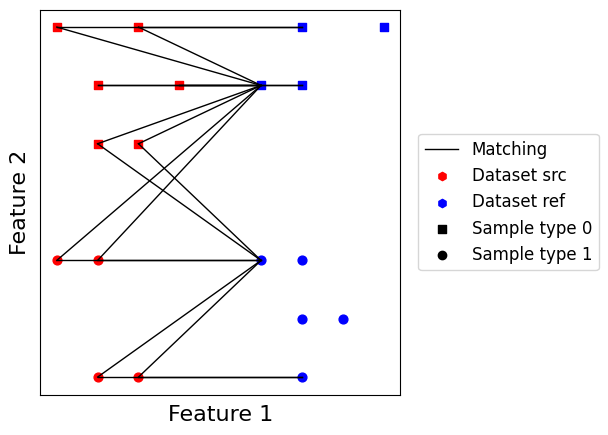

In [36]:
scatter_plot_with_matching(datasets, get_matching_matrix(model_bknn))

## Mutual nearest neighbors matching

For $k$ a positive integer, $k$-[mutual nearest neighbors](https://www.nature.com/articles/nbt.4091) is an alternative to batch $k$-nearest neighbors. It tends to provide higher quality edges than batch $k$-nearest neighbors, at the cost of increased computation time and lesser edges number. The idea is to compute reciprocal batch $k$-nearest neighbors between two batches, and only keep the intersection of both edge sets. 

Mutual $k$-nearest neighbors tends to yield high quality matchings, inheriting all good properties from batch $k$-nearest neighbors, while also being symmetrical. IT also works under the assumption batch effect is orthogonal to biological effect, and always returns a smaller number of edges compared to batch $k$-nearest neighbors. This fact often induces in practice the need to tune up $k$ parameter, in order to have enough matching edges for subsequent pipeline steps to be stable.

In [39]:
from transmorph.engine.matching import MNN

# We use n_neighbors=3 to have more edges at the end
model_mnn = create_model_matching(MNN(n_neighbors=3))
model_mnn.fit(datasets)

CUSTOM_MODEL > Transmorph model is initializing.
CUSTOM_MODEL > Ready to start the integration of 2 datasets, 19 total samples.
CUSTOM_MODEL > Running layer LAYER_INPUT#38.
CUSTOM_MODEL > Running layer LAYER_MATCHING#39.
LAYER_MATCHING#39 > Calling matching MATCHING_MNN.


As we can see, this generates much less edges than the previous batch $k$-nearest neighbors matching. We also notice many points are left unmatched. On the other hand, edges are of higher quality, and matching is symmetrical independently from the choice of query or reference. For applications where false positive are a real issue, we suggest this matching to be preferrable over batch $k$-nearest neighbors.

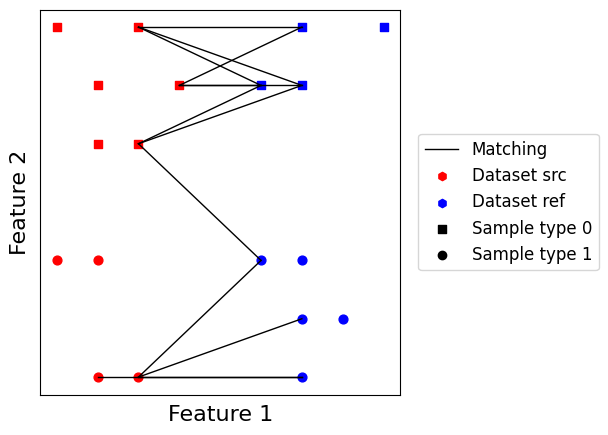

In [40]:
scatter_plot_with_matching(datasets, get_matching_matrix(model_mnn))

## Discrete transportation-based matchings

Discrete optimal transport (OT) problem can be naturally pictured as follows. Assuming a set of $n$ warehouses containing goods to deliver to $m$ factories, the optimal transport problem is to look for the cheapest plan to transport all goods to factories knowing transport cost is proportional to both mass carried and distance traveled. Originally brought into the field as a way to [predict cell fate](https://www.cell.com/cell/fulltext/S0092-8674(19)30039-X), it has also been shown to be an interesting concept for dataset integration in tools [SCOT](https://www.liebertpub.com/doi/10.1089/cmb.2021.0446) and [Pamona](https://academic.oup.com/bioinformatics/article/38/1/211/6353029).

### Exact optimal transport

We use the great [POT](https://pythonot.github.io/) optimal transport library to carry out the computations. For more information about optimal transport, do not hesitate to look at their documentation. On this first example, we use the exact optimal transport formulation. It does not require tuning any hyperparameter, but can struggle to scale to very large datasets.

In [12]:
from transmorph.engine.matching import OT

model_ot = create_model_matching(OT())
model_ot.fit(datasets)

CUSTOM_MODEL > Transmorph model is initializing.
CUSTOM_MODEL > Ready to start the integration of 2 datasets, 19 total samples.
CUSTOM_MODEL > Running layer LAYER_INPUT#10.
CUSTOM_MODEL > Running layer LAYER_MATCHING#11.
LAYER_MATCHING#11 > Calling matching MATCHING_OT.


J:\Code\PHD\transmorph_package\transmorph\src\transmorph\engine\traits\canlog.py:64: UserWarning: No output layer reachable from input. This pipeline will not write results in AnnData objects.
  warnings.warn(msg)


One of the most important properties of optimal transport matching is that every point in both dataset is matched with at least another point. Furthermore, matching is fuzzy meaning non-integer values are allowed. Optimal transport will tend to leverage dataset topology together with relative orientation to provide a matching, using distribution-level information instead of only relying on local information like nearest neighbors.

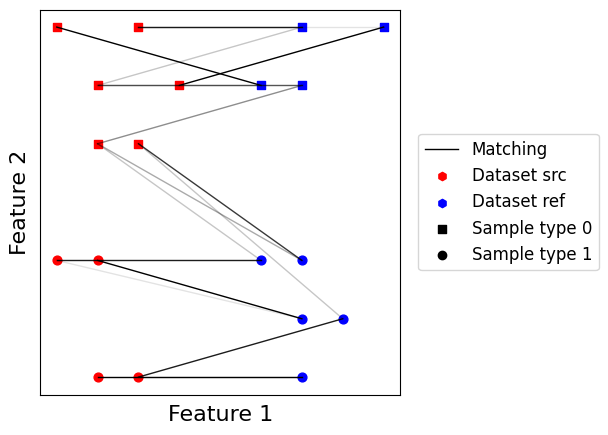

In [13]:
scatter_plot_with_matching(datasets, get_matching_matrix(model_ot))

### Approximate optimal transport

When dealing with larger datasets, switching to an approximate solution of optimal transport can greatly improve computational efficiency. The most common trick is to use an entropy regularized formulation of optimal transport, which can be optimized using the Sinkhorn-Knopp algorithm. The OT matching can compute this approximation, and the amplitude of the regularizer term can be controlled using the *sinkhorn_reg* parameter.

In [43]:
from transmorph.engine.matching import OT

model_ots = create_model_matching(OT(solver="sinkhorn", sinkhorn_reg=1e-2))
model_ots.fit(datasets)

CUSTOM_MODEL > Transmorph model is initializing.
CUSTOM_MODEL > Ready to start the integration of 2 datasets, 19 total samples.
CUSTOM_MODEL > Running layer LAYER_INPUT#42.
CUSTOM_MODEL > Running layer LAYER_MATCHING#43.
LAYER_MATCHING#43 > Calling matching MATCHING_OT.


J:\Code\PHD\transmorph_package\transmorph\src\transmorph\engine\traits\canlog.py:64: UserWarning: No output layer reachable from input. This pipeline will not write results in AnnData objects.
  warnings.warn(msg)


As we can see, the estimated transport plan is even fuzzier than with regular optimal transport. This reduces the efficiency of storing matchings within sparse matrices. The matching is still quite reasonable though, and can scale to large datasets.

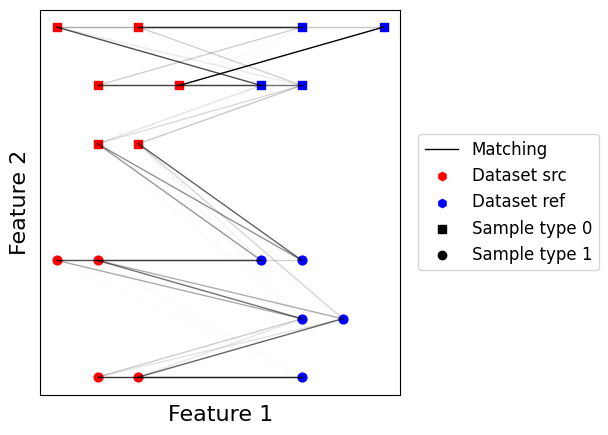

In [44]:
scatter_plot_with_matching(datasets, get_matching_matrix(model_ots))

### Unbalanced optimal transport

A defining feature of optimal transport is the necessity to move all mass from source distribution to target distribution. This can be a real issue, especially in single-cell, when dealing with datasets containing unbalanced cell types. A workaround is to use another alternative formaulation of optimal transport which does not enforce the transport of all mass but rather penalizes on non-transported or over-transported mass. This relaxation allows in practice to successfully apply optimal transport to such unbalanced scenarios.

In [46]:
from transmorph.engine.matching import OT

# We can control both entropy regularizer amplitude and
# mass penalty amplitude.
model_otu = create_model_matching(OT(solver="unbalanced", sinkhorn_reg=2e-2, unbalanced_reg=1e-1))
model_otu.fit(datasets)

CUSTOM_MODEL > Transmorph model is initializing.
CUSTOM_MODEL > Ready to start the integration of 2 datasets, 19 total samples.
CUSTOM_MODEL > Running layer LAYER_INPUT#46.
CUSTOM_MODEL > Running layer LAYER_MATCHING#47.
LAYER_MATCHING#47 > Calling matching MATCHING_OT.


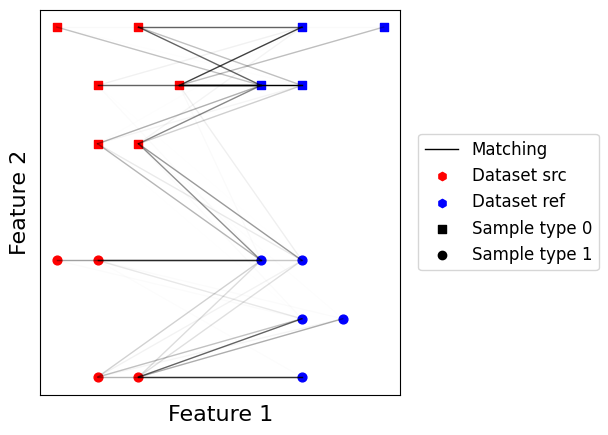

In [47]:
scatter_plot_with_matching(datasets, get_matching_matrix(model_otu))

### Adapting optimal transport to non-overlapping spaces

In the situations where datasets do not belong to a common space and cannot be easily projected into one, the Gromov-Wasserstein problem can be used as an alternative for optimal transport. It leverages pairwise distances between points within each dataset to seek topological similarity between them. In practice though, it can be quite deceiving as constraints are weaker than the optimal transport formulations.

In [16]:
from transmorph.engine.matching import GW

model_gw = create_model_matching(GW())
model_gw.fit(datasets)

CUSTOM_MODEL > Transmorph model is initializing.
CUSTOM_MODEL > Ready to start the integration of 2 datasets, 19 total samples.
CUSTOM_MODEL > Running layer LAYER_INPUT#14.
CUSTOM_MODEL > Running layer LAYER_MATCHING#15.
LAYER_MATCHING#15 > Calling matching MATCHING_GW.


As we can see, the GW solver has inverted here the optimal matching between point classes. This can be explained here by the class imbalance between datasets. This motivates the need to only use Gromov-Wasserstein when there is no other option available.

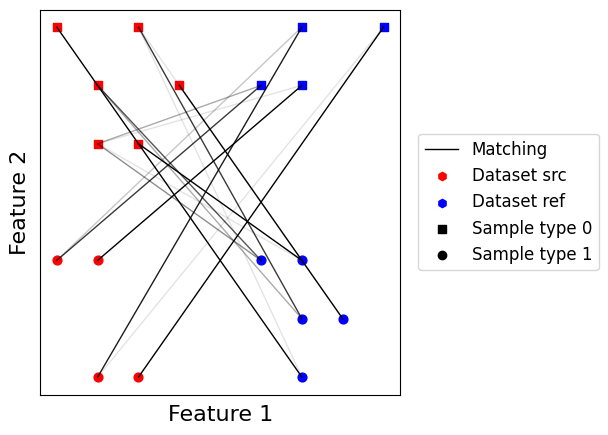

In [17]:
scatter_plot_with_matching(datasets, get_matching_matrix(model_gw))

### Fused Gromov-Wasserstein matching

A last interesting option to consider is a problem taking into account both optimal transport and Gromov-Wasserstein. Doing so, we leverage both datasets intrinsic geometry and pairwise relative geometry. The *alpha* parameter controls the balance between Gromov-Wasserstein and optimal transport, 0 being pure optimal transport and 1 being pure Gromov-Wasserstein.

In [62]:
from transmorph.engine.matching import FusedGW

model_fgw = create_model_matching(FusedGW(alpha=0.1))
model_fgw.fit(datasets)

CUSTOM_MODEL > Transmorph model is initializing.
CUSTOM_MODEL > Ready to start the integration of 2 datasets, 19 total samples.
CUSTOM_MODEL > Running layer LAYER_INPUT#62.
CUSTOM_MODEL > Running layer LAYER_MATCHING#63.
LAYER_MATCHING#63 > Calling matching MATCHING_FUSEDGW.


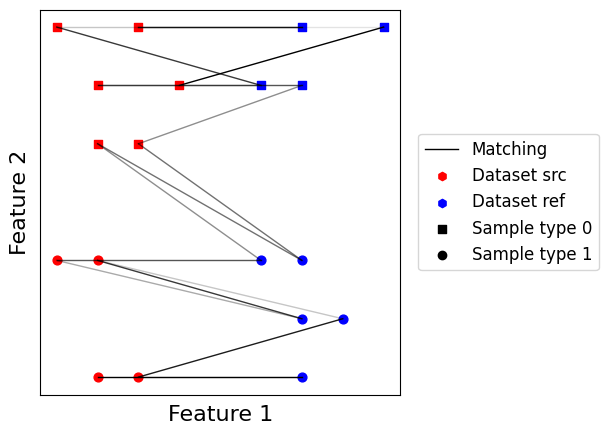

In [63]:
scatter_plot_with_matching(datasets, get_matching_matrix(model_fgw))

## Creating a custom matching module

**transmorph** also allows the user to define their own matching algorithm, that can then be used within a data integration pipeline, similarly to transformation modules. Every module is implemented as an object whose attributes are parameters. Doing so, it is easy to add new algorithms by following a few specifications.

To illustrate how to create a matching module, let us define a toy matching algorithm. It attributes random edges across datasets following a Bernouilli sampling scheme. Any matching must implement at least two methods. *check_input*, which takes as input the set of embeddings to transform and which raises an exception if they are invalid. For instance, it can be used to check if all embeddings are in a feature space of the same size, or if all coefficients are nonnegative.

The second method to implement is the *fit* method, which takes as input a list of embeddings to match provided as numpy arrays. There is no need to explicitly call check_input within the transform method, as this is taken care of by the transmorph engine. This method should carry out the necessary computations, and return a dictionary which associates index pairs (i, j) to the corresponding matching stored as a CSR sparse matrix.

In [29]:
from transmorph.engine.matching import Matching, _TypeMatchingSet
from scipy.sparse import csr_matrix

import numpy as np


class CustomMatchingRandom(Matching):
    
    def __init__(self, edge_rate: float):
        # str_identifier is the string name of the module
        Matching.__init__(self, str_identifier="RandomMatching")
        self.edge_rate = edge_rate
        
    def check_input(self, datasets: List[np.ndarray]) -> None:
        """
        This method must be overriden. It can perform a checking over
        embeddings on which the matching will take place, to
        verify they all fulfill desired properties. If not, it can raise
        an exception.

        Example: Only accepts embeddings of same features number.
        """
        assert all(X.shape[1] == datasets[0].shape[1] for X in datasets),\
            "All embeddings must be of same features size."
    
    def fit(self, datasets: List[np.ndarray]) -> _TypeMatchingSet:
        """
        This method must be overriden. It takes as input in the same order the list
        of AnnData objects and the current embedding state (i.e. the one obtained after
        the latest transformation). It must return a dictionary which associates 
        index pairs (i, j) to the corresponding matching stored as a CSR sparse matrix.
        """
        # _TypeMatchingSet: Dict[Tuple[int, int], csr_matrix]
        result: _TypeMatchingSet = {}
        for i, Xi in enumerate(datasets):
            for j, Xj in enumerate(datasets):
                if i == j:
                    continue
                T = (np.random.random((Xi.shape[0], Xj.shape[0])) < self.edge_rate)
                result[i, j] = csr_matrix(T.astype(float))
        return result

We can now use this new matching within a classic transmorph model!

In [32]:
from transmorph.engine.matching import FusedGW

model_random = create_model_matching(CustomMatchingRandom(edge_rate=0.1))
model_random.fit(datasets)

CUSTOM_MODEL > Transmorph model is initializing.
CUSTOM_MODEL > Ready to start the integration of 2 datasets, 19 total samples.
CUSTOM_MODEL > Running layer LAYER_INPUT#30.
CUSTOM_MODEL > Running layer LAYER_MATCHING#31.
LAYER_MATCHING#31 > Calling matching MATCHING_RandomMatching.


J:\Code\PHD\transmorph_package\transmorph\src\transmorph\engine\traits\canlog.py:64: UserWarning: No output layer reachable from input. This pipeline will not write results in AnnData objects.
  warnings.warn(msg)


But as expected for a random matching, the output is terrible :-)

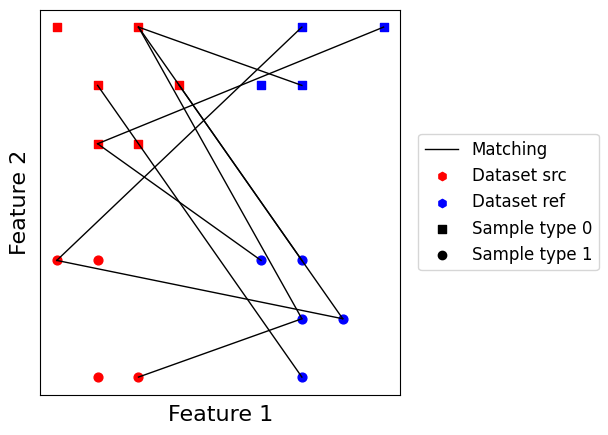

In [33]:
scatter_plot_with_matching(datasets, get_matching_matrix(model_random))